In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.metrics import roc_auc_score , accuracy_score , precision_score, recall_score ,confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import h5py
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
BASE_DIR = os.getcwd()

In [3]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/Epileptic Seizure Recognition.csv')

In [5]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,1.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,2.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,3.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,4.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,5.000000


In [7]:
data.shape

(11500, 180)

### Visualization

In [8]:
data.describe(include=object)

,Unnamed
count,11500
unique,11500
top,X21.V1.791
freq,1


In [9]:
null_values = data.isnull().sum()
null_values.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [10]:
data_1 = data.copy()

In [11]:
data_1.drop(['Unnamed','y'],axis=1,inplace=True)

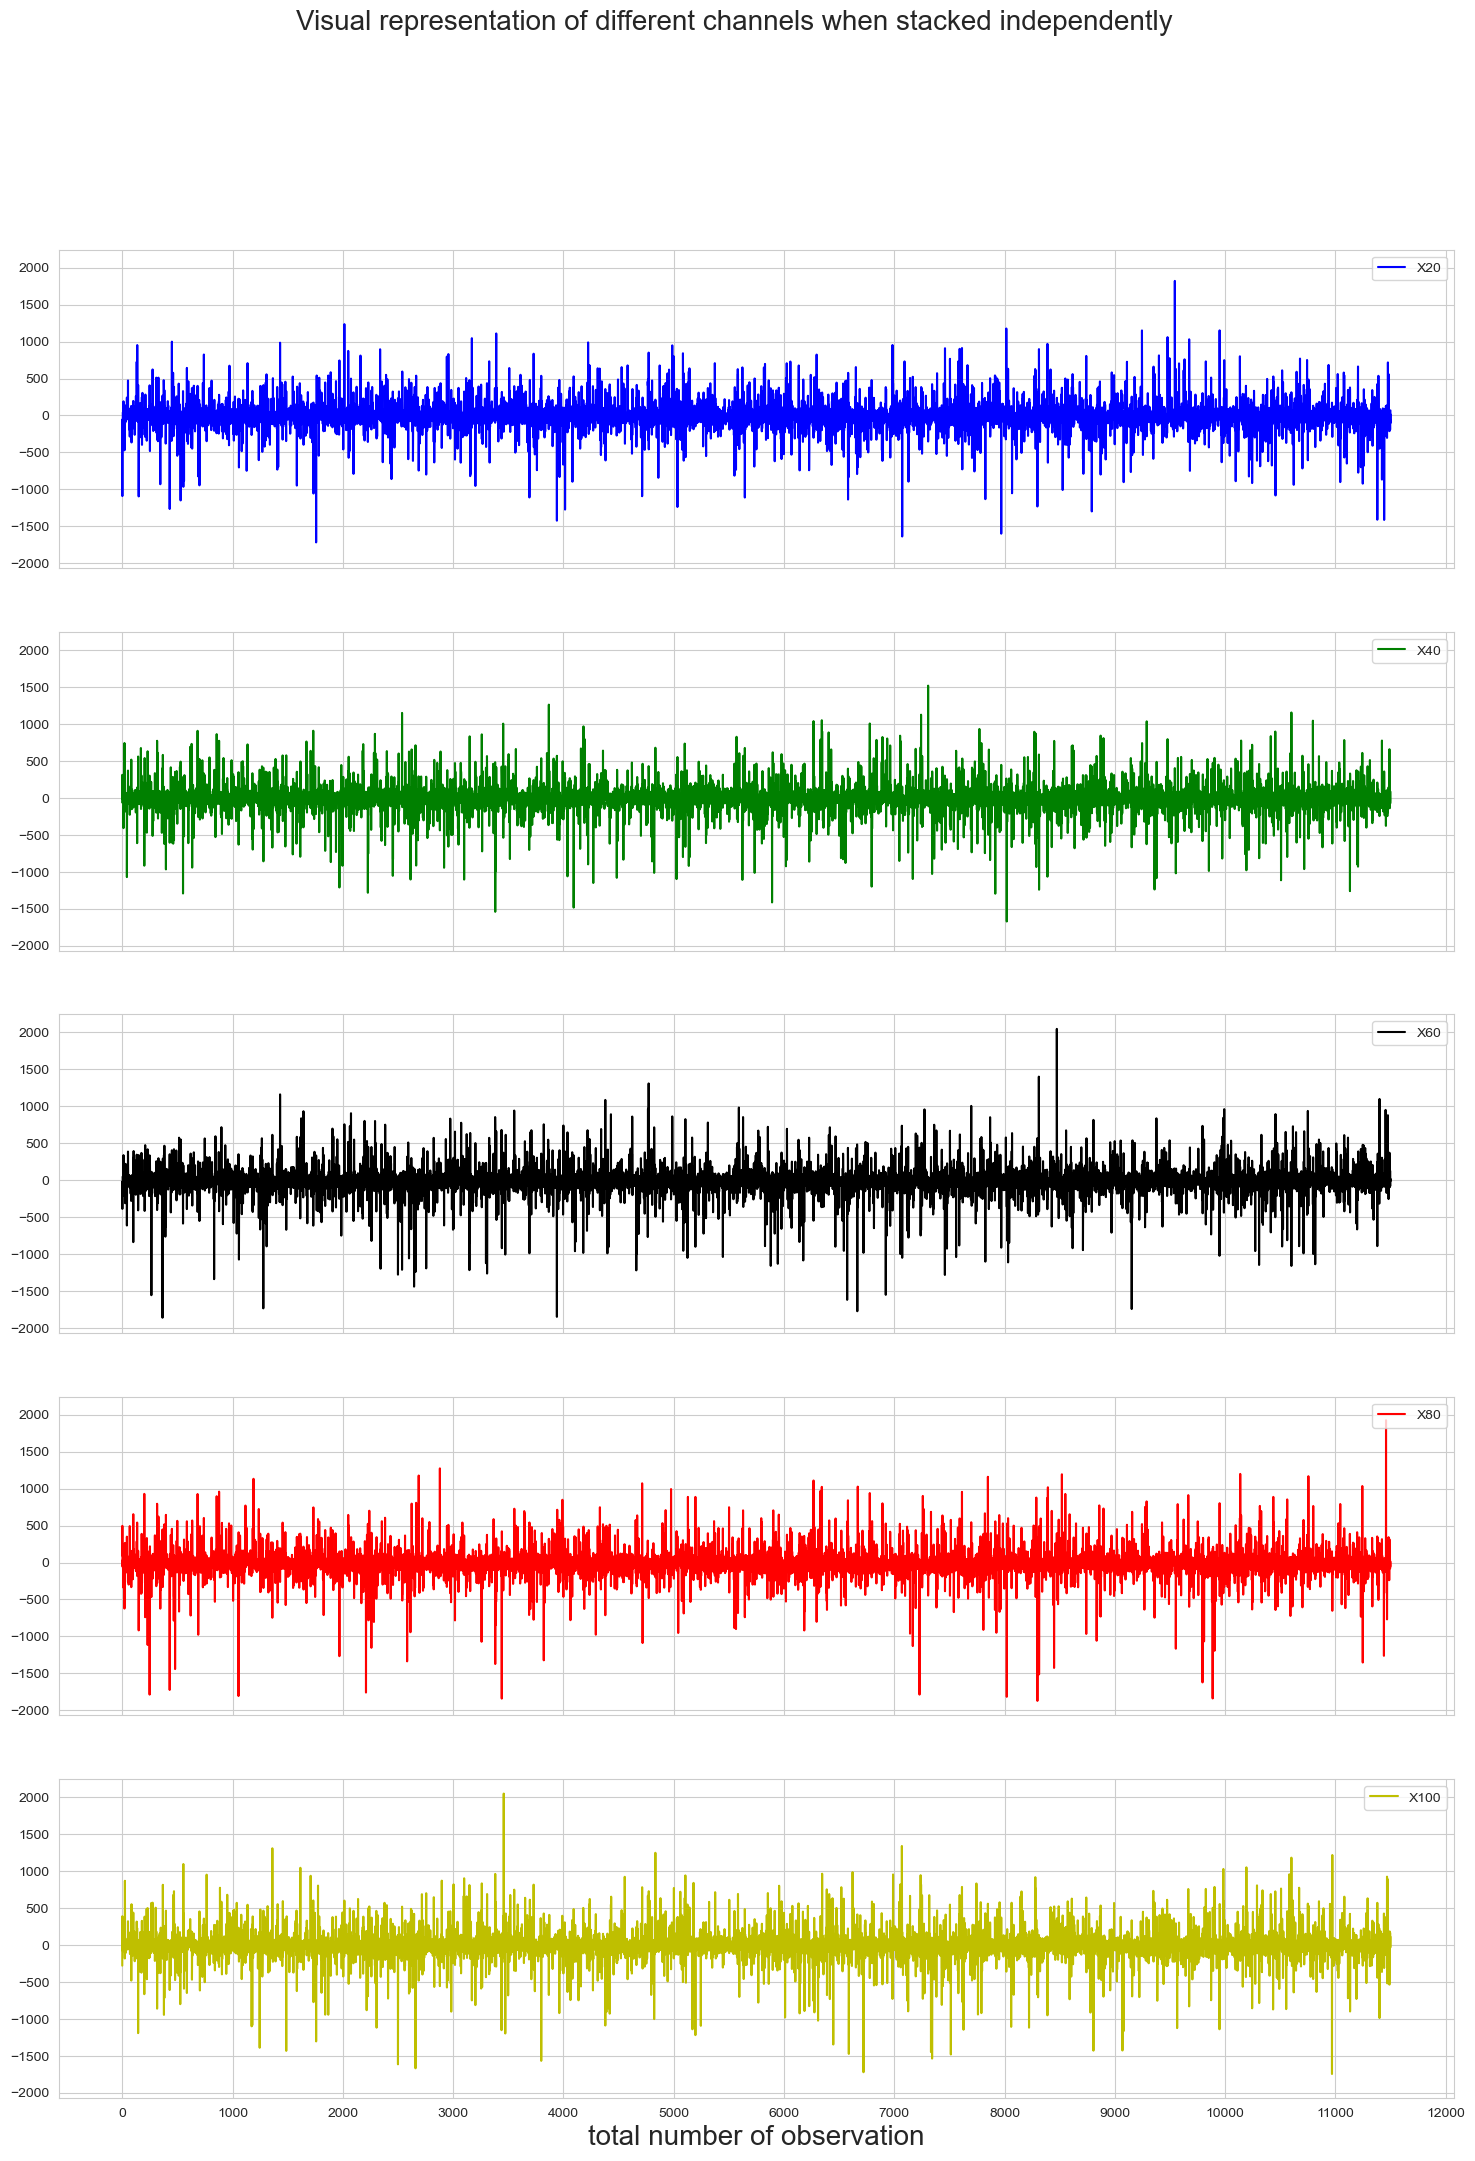

In [12]:
fig, axs = plt.subplots(5, sharex=True, sharey=True)
fig.set_size_inches(18, 24)
labels = ["X20","X40","X60","X80","X100"]
colors = ["b","g","k","r","y"]
fig.suptitle('Visual representation of different channels when stacked independently', fontsize = 20)
for i,ax in enumerate(axs):
  axs[i].plot(data.iloc[:,0],data[labels[i]],color=colors[i],label=labels[i])
  axs[i].legend(loc="upper right")


plt.xlabel('total number of observation', fontsize = 20)
x_ticks = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]
x_ticklabels = ['0', '1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', '9000', '10000', '11000', '12000']
plt.xticks(x_ticks, x_ticklabels)
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'independent_channel.png'))
plt.show()

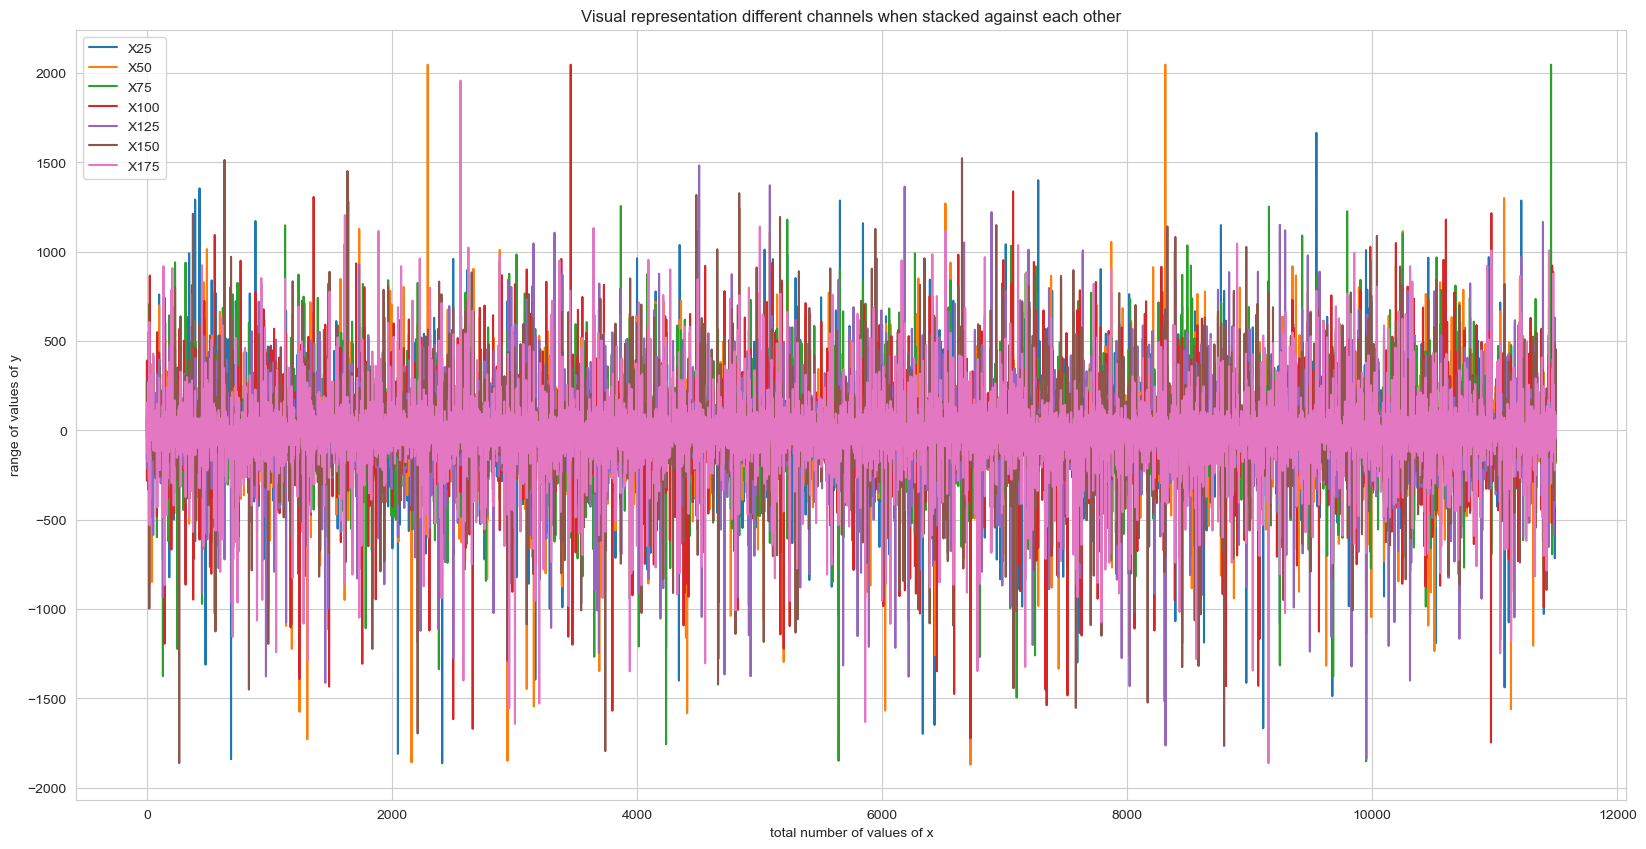

In [13]:
plt.rcParams["figure.figsize"] = (20, 10)
data.loc[:,::25].plot()
plt.title("Visual representation different channels when stacked against each other")
plt.xlabel("total number of values of x")
plt.ylabel("range of values of y")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'stacked_channels.png'))
plt.show()

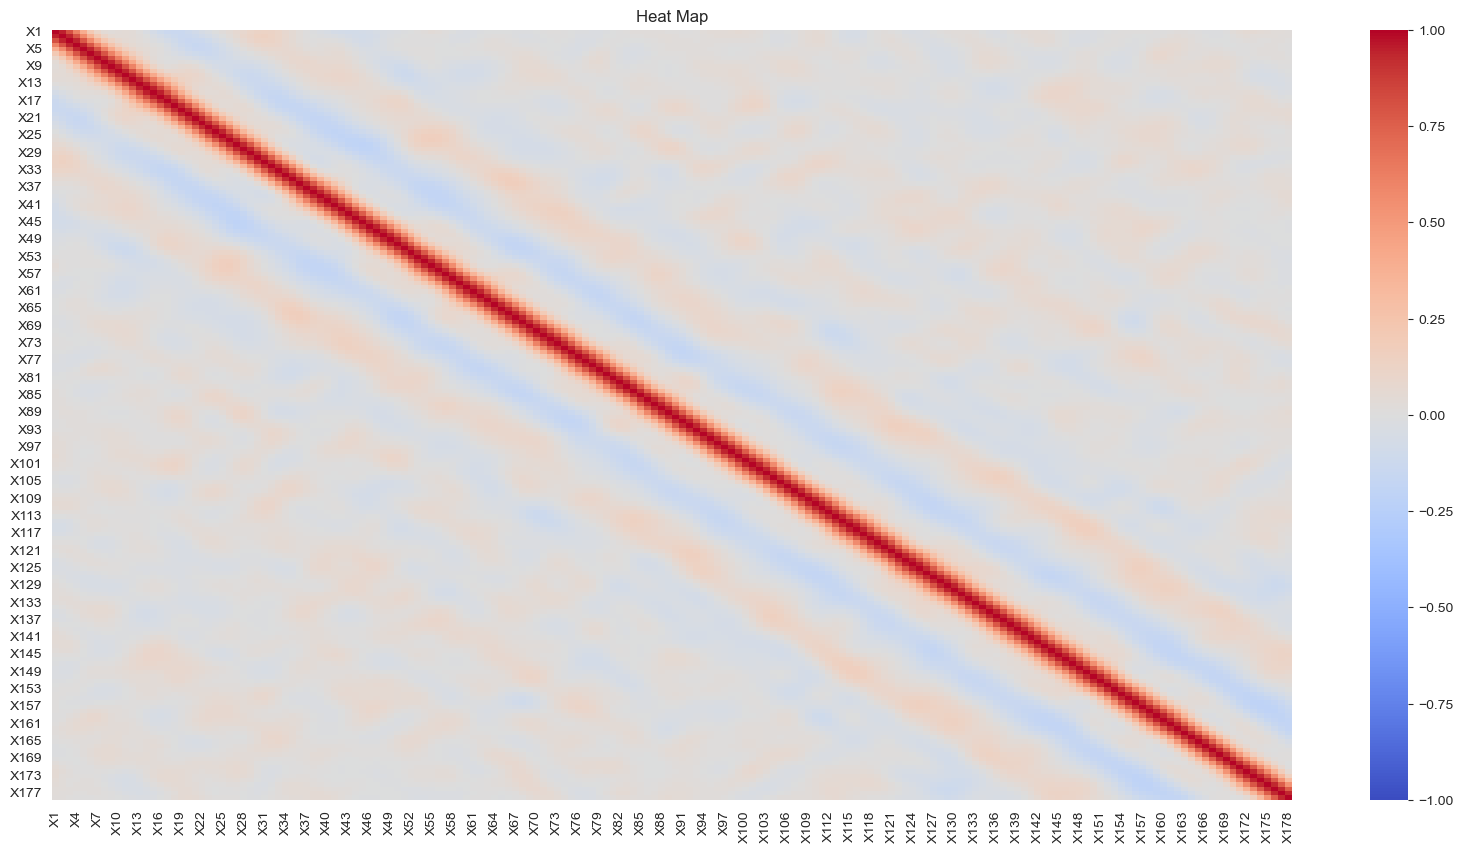

In [14]:
corr = data_1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm'
)
plt.title("Heat Map")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img','heat_map.png'))
plt.show()

### Solve Class Imbalance

In [15]:
data_2 = data.drop(["Unnamed"],axis=1).copy()

In [16]:
data_2.y.value_counts()

4    2300
1    2300
5    2300
2    2300
3    2300
Name: y, dtype: int64

In [17]:
data_2['y'] = data_2['y'].replace([2,3,4,5],0)

In [18]:
data_2.y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

In [19]:
data_2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


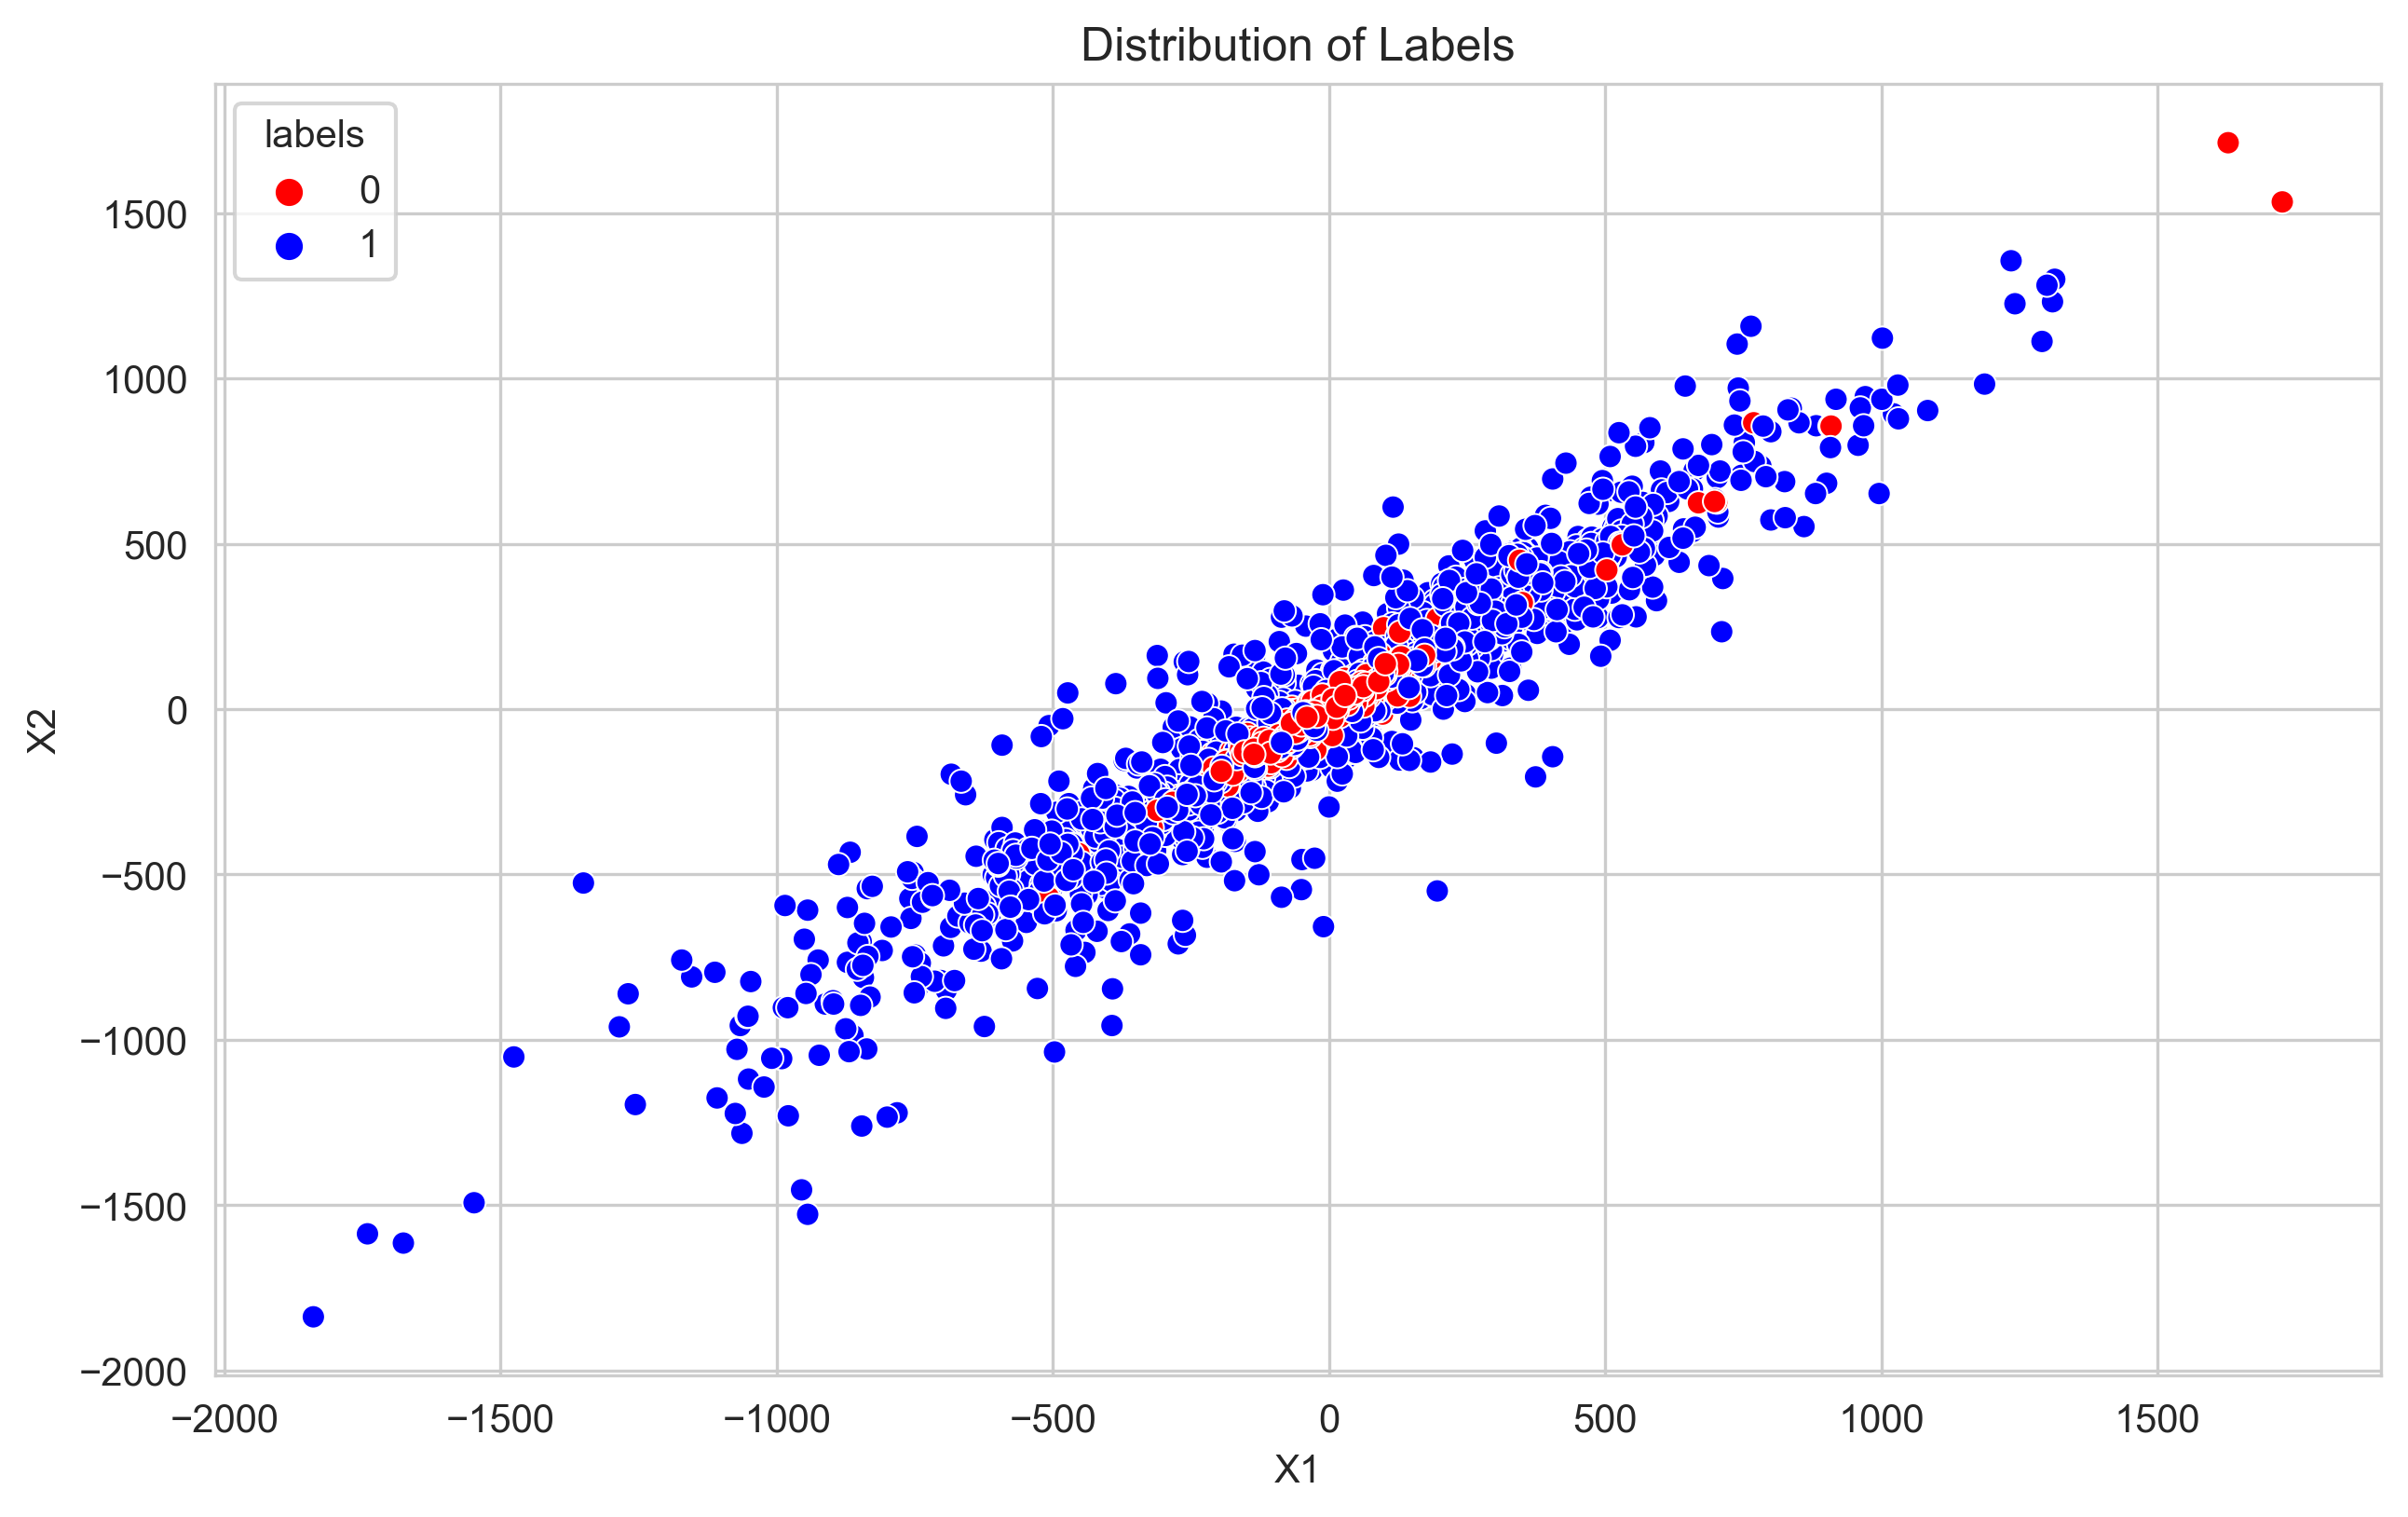

In [20]:
plt.figure(figsize=(10,6),dpi=300)
sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'y', data=data_2, palette=['red', 'blue'])
plt.title('Distribution of Labels')
plt.legend(loc='upper left', title="labels")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'scatter_plot.png'))
plt.show()

In [21]:
data_2.y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

In [22]:
X  = data_2.drop(['y'], axis=1)
y = data_2['y']

In [23]:
counter = Counter(y)
print('Before',counter)
smenn = SMOTEENN()
X_train1, y_train1 = smenn.fit_resample(X, y)
counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 9200, 1: 2300})
After Counter({0: 9074, 1: 9047})


In [24]:
# Save data for using in Django
X_train1.to_csv(os.path.join(BASE_DIR, 'data', 'data.csv'), index=False)
y_train1.to_csv(os.path.join(BASE_DIR,'data', 'labels.csv'), index=False)

### Train/Test/Validation Dataset Splitting


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_train1,y_train1,test_size=0.2,random_state=42)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=42)

### Feature Scaling

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [28]:
print(f"The shape of the training set is :{X_train.shape}")
print(f"The shape of the testing set is :{X_test.shape}")
print(f"The shape of the validation set is :{X_val.shape}")

The shape of the training set is :(10872, 178)
The shape of the testing set is :(3625, 178)
The shape of the validation set is :(3624, 178)


### Logistic Regression

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
# Save Logistic Regression Model
lg_filename = 'LogisticRegressionModel.pickle'
with open(os.path.join(BASE_DIR, "model", lg_filename), 'wb') as f:
    pickle.dump(logreg, f)

In [31]:

y_pred = logreg.predict(X_val)
print(f"The accuracy score of the model on the validation data is:{metrics.accuracy_score(y_val, y_pred)*100:.2f}.")

The accuracy score of the model on the validation data is:64.40.


In [32]:
models_dataframe = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['LogisticView'],
    'SavedModelName': [f'{lg_filename}']
})

In [33]:
logit_fpr, logit_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
logit_auc = metrics.roc_auc_score(y_val, y_pred)

### KNN

In [34]:
pipe = Pipeline([('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [9,10, 100]}
knn = GridSearchCV(pipe, param_grid, cv=5)

knn.fit(X_train,y_train)
print('Best hyperparameters:', knn.best_params_)
# Save KNN Model
knn_filename = 'KNNModel.pickle'
with open(os.path.join(BASE_DIR, "model", knn_filename), 'wb') as f:
    pickle.dump(knn, f)

Best hyperparameters: {'knn__n_neighbors': 9}


In [35]:
y_pred = knn.predict(X_val)
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
knn_auc = metrics.roc_auc_score(y_val, y_pred)
y_valid_preds = knn.predict_proba(X_val)
precision = metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100
print(f"Accuracy with K-NN: {precision:.2f}%")

Accuracy with K-NN: 96.11%


In [36]:
new_row = pd.DataFrame({
    'Model': ['KNN'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['KNNView'],
    'SavedModelName': [f'{knn_filename}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Support Vector Machine

In [37]:
clf = svm.SVC(kernel='poly', C=100, gamma=0.01, probability=True)
clf.fit(X_train, y_train)


SVC(C=100, gamma=0.01, kernel='poly', probability=True)

In [38]:
# Save SVM Model
svm_filename = 'SVMModel.pickle'
with open(os.path.join(BASE_DIR, "model", svm_filename), 'wb') as f:
    pickle.dump(clf, f)

In [39]:
y_pred = clf.predict(X_val)
precision = metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100
print(f"Accuracy with SVM: {precision:.2f}%")
probs = clf.predict_proba(X_val)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_val, probs)
svm_auc = metrics.roc_auc_score(y_val, probs)

Accuracy with SVM: 92.80%


In [40]:
new_row = pd.DataFrame({
    'Model': ['SVM'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['SVMView'],
    'SavedModelName': [f'{svm_filename}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Naive Bayes Classifier

In [41]:
naive = GaussianNB()
naive.fit(X_train,y_train)
# Save NaiveBayes Model
nb_filename = 'NaiveBayesModel.pickle'
with open(os.path.join(BASE_DIR, "model", nb_filename), 'wb') as f:
    pickle.dump(naive, f)


In [42]:
y_pred = naive.predict(X_val)
naive_fpr, naive_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
naive_auc = metrics.roc_auc_score(y_val, y_pred)
print(f'Accuracy with naive is:{metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100:.2f}%.')

Accuracy with naive is:91.17%.


In [43]:
new_row = pd.DataFrame({
    'Model': ['Naive Bayes'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['NaiveBayesView'],
    'SavedModelName': [f'{svm_filename}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Random Forest Classifier

In [44]:
random = RandomForestClassifier(max_depth=10,random_state=69)
random.fit(X_train,y_train)

# Save RF Model
rf_filename = 'RandomForestModel.pickle'
with open(os.path.join(BASE_DIR, "model", rf_filename), 'wb') as f:
    pickle.dump(random, f)


In [45]:
#predicting
y_pred = random.predict(X_val)
random_fpr, random_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
random_auc = metrics.roc_auc_score(y_val, y_pred)
#Evaluating the model
precision = metrics.accuracy_score(y_pred=y_pred,y_true=y_val)* 100
#print  the accuracy
print(f"Accuracy of the model by using the random forest algorithm : {precision:.2f}%")

Accuracy of the model by using the random forest algorithm : 96.61%


In [46]:
new_row = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['RandomForestView'],
    'SavedModelName': [f'{rf_filename}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### XgBoost

In [47]:
xgbc = XGBClassifier()

xgbc.fit(X_train,y_train)

# Save SVM Model
xg_filename = 'XgBoostModel.pickle'
with open(os.path.join(BASE_DIR, "model", xg_filename), 'wb') as f:
    pickle.dump(xgbc, f)

In [48]:
#predicting
y_pred = xgbc.predict(X_val)
xgbc_fpr, xgbc_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
xgbc_auc = metrics.roc_auc_score(y_val, y_pred)
#Evaluating the model
precision = metrics.accuracy_score(y_pred=y_pred,y_true=y_val)* 100
#print  the accuracy
print(f"Accuracy of the model by using the xgbc algorithm : {precision:.2f}%")

Accuracy of the model by using the xgbc algorithm : 98.45%


In [49]:
new_row = pd.DataFrame({
    'Model': ['XgBoost'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['XgBoostView'],
    'SavedModelName': [f'{xg_filename}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### ROC Curve

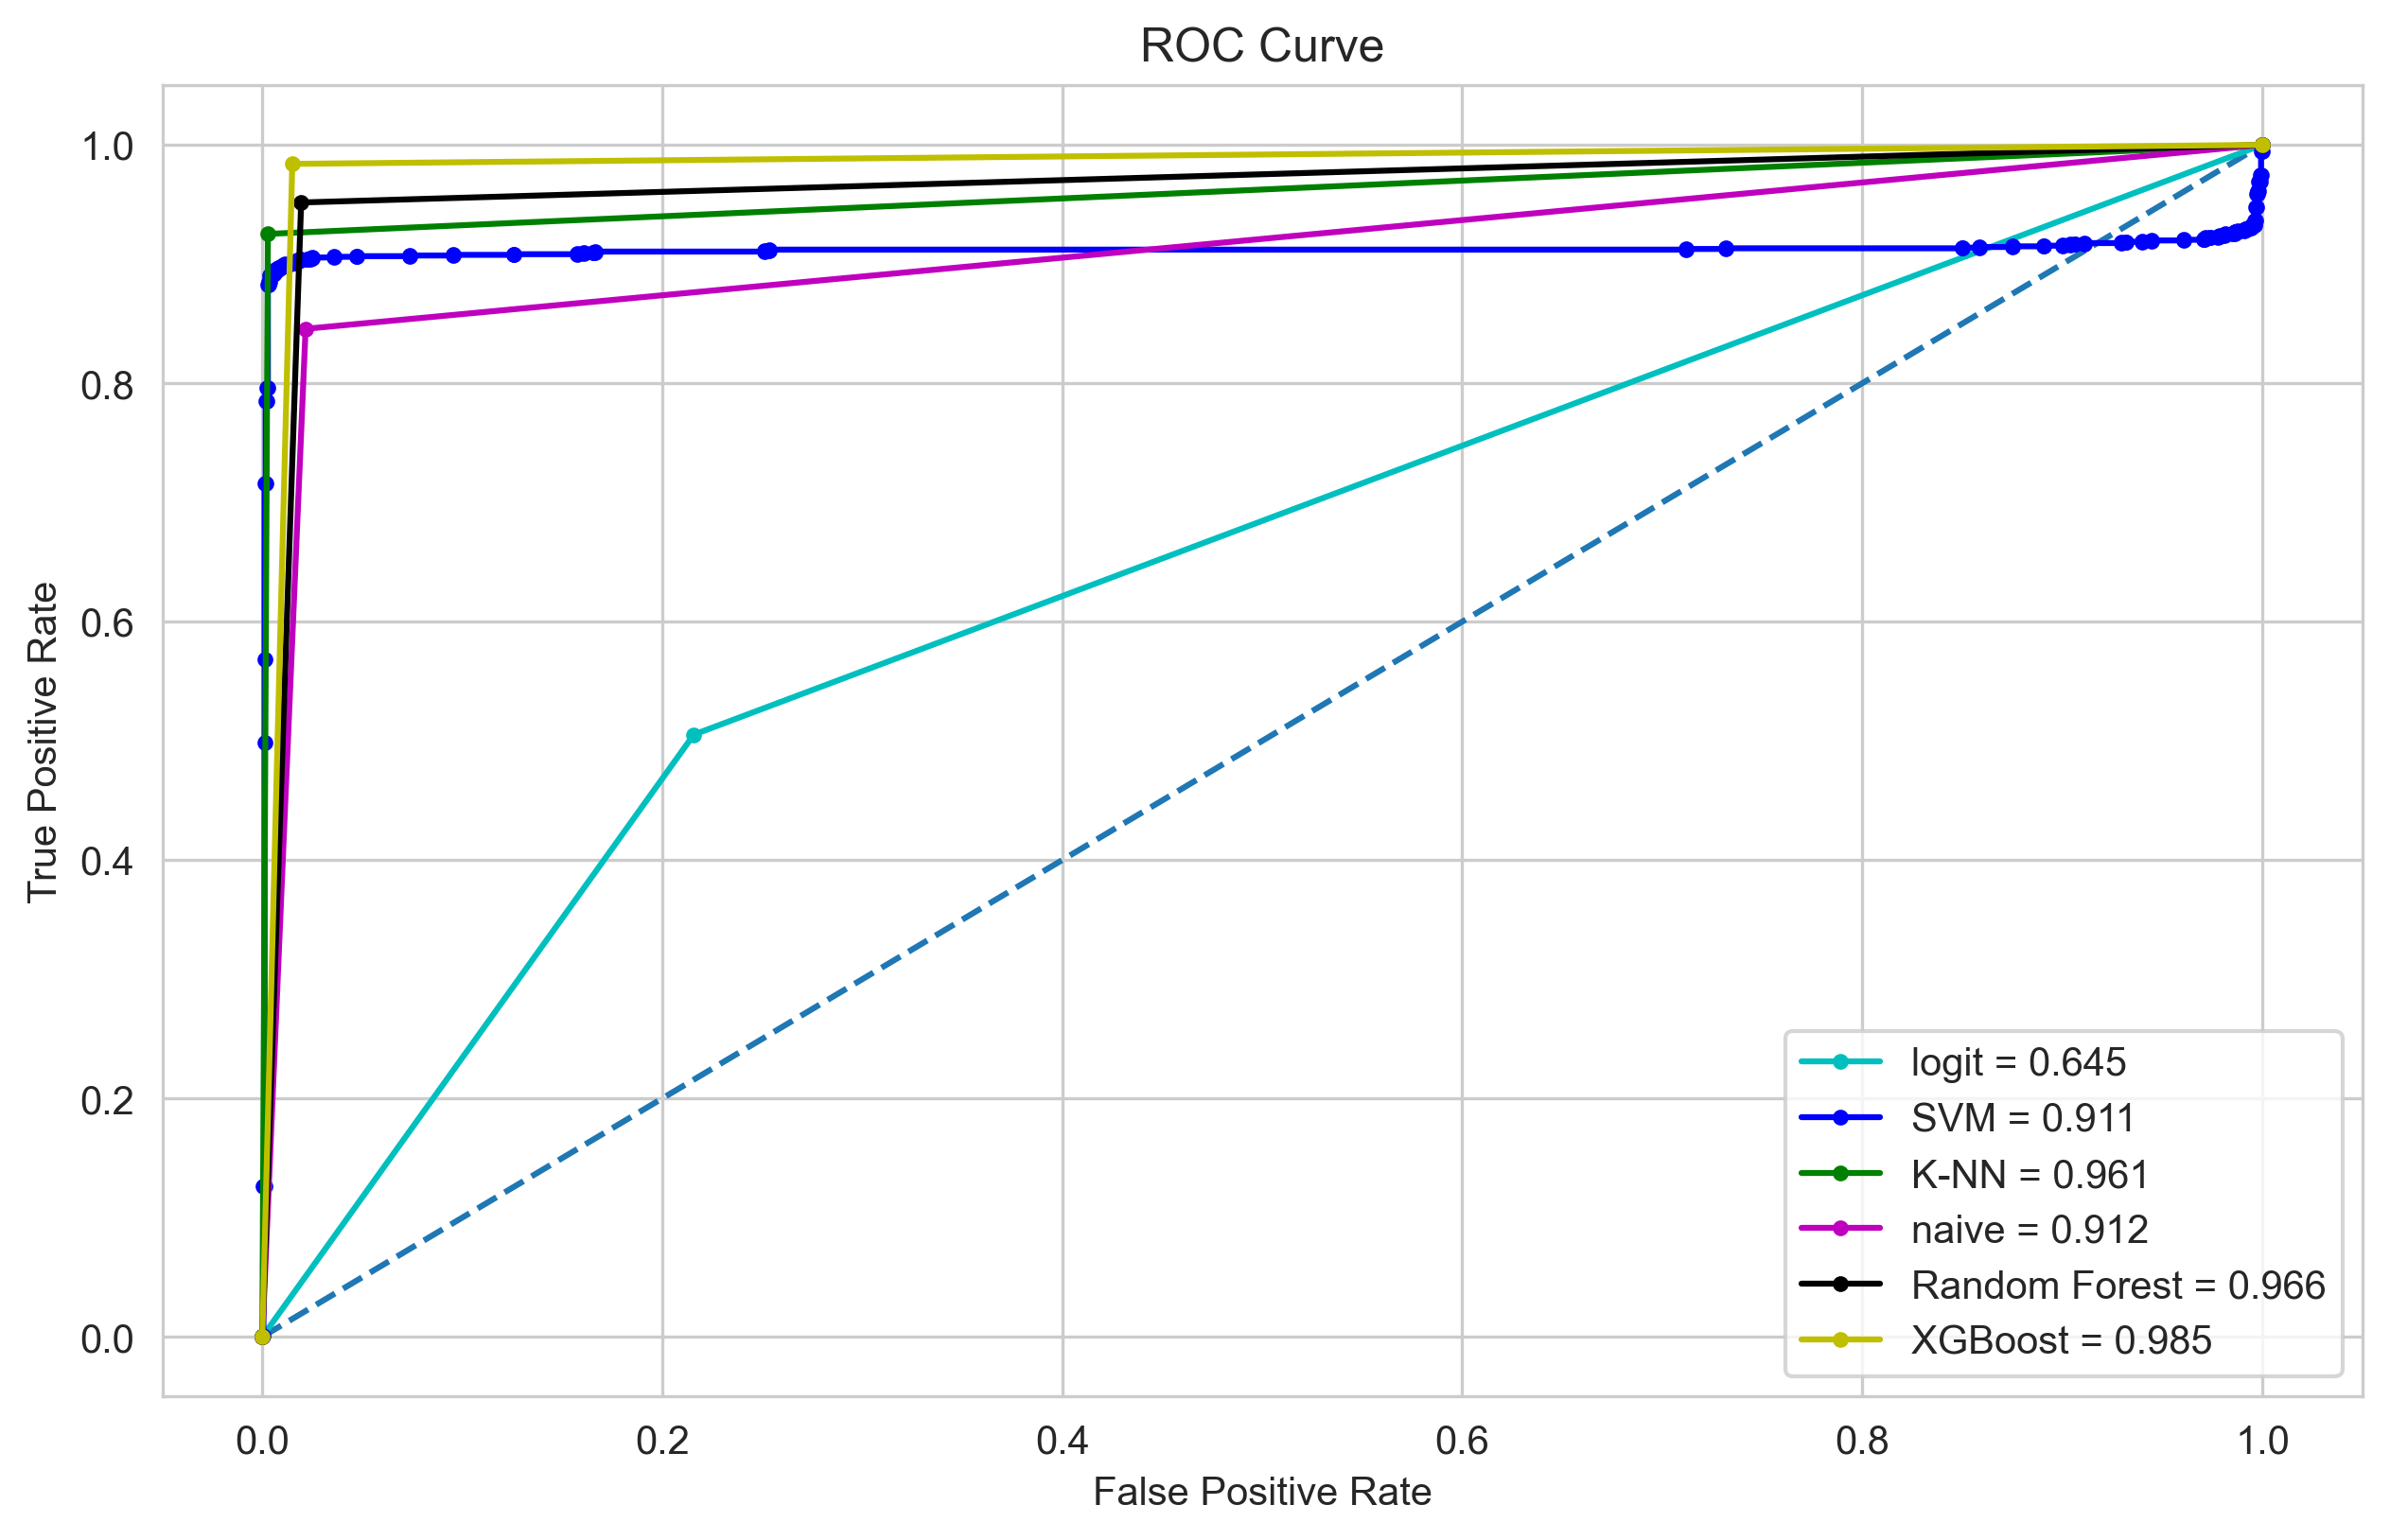

In [50]:
plt.figure(figsize=(10,6),dpi=300)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(logit_fpr, logit_tpr, 'c', marker='.', label = 'logit = %0.3f' % logit_auc )
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(naive_fpr, naive_tpr, 'm', marker='.', label = 'naive = %0.3f' % naive_auc)
plt.plot(random_fpr, random_tpr, 'k', marker='.',label = 'Random Forest = %.3f' % random_auc)
plt.plot(xgbc_fpr, xgbc_tpr, 'y', marker='.',label = 'XGBoost = %.3f' % xgbc_auc)


plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'roc_curve.png'), dpi=100)
plt.show()

### Deep Learning

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

In [52]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

In [53]:
model1 = Sequential()
model1.add(layers.Reshape((178, 1, 1), input_shape=(178,)))
model1.add(layers.Conv2D(filters=32, kernel_size=(10, 1), activation='relu', input_shape=(178, 1, 1)))
model1.add(layers.MaxPooling2D(pool_size=(3, 1)))
model1.add(layers.Conv2D(filters=64, kernel_size=(10, 1), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(3, 1)))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(units=1, activation='sigmoid'))

# model Summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 178, 1, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 169, 1, 32)        352       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 1, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 1, 64)         20544     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 1, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 960)               0

In [54]:
# Compile the model
model1.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.001),
               metrics=['accuracy',  Precision(), Recall()])


# Train the model
history = model1.fit(X_train, y_train,
                     epochs=500,
                     batch_size=32,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/500
340/340 [==============================] - 7s 10ms/step - loss: 0.1821 - accuracy: 0.9216 - precision: 0.8957 - recall: 0.9534 - val_loss: 0.0946 - val_accuracy: 0.9699 - val_precision: 0.9683 - val_recall: 0.9720
Epoch 2/500
340/340 [==============================] - 3s 8ms/step - loss: 0.0984 - accuracy: 0.9673 - precision: 0.9674 - recall: 0.9669 - val_loss: 0.1057 - val_accuracy: 0.9611 - val_precision: 0.9855 - val_recall: 0.9363
Epoch 3/500
340/340 [==============================] - 3s 8ms/step - loss: 0.0799 - accuracy: 0.9713 - precision: 0.9715 - recall: 0.9708 - val_loss: 0.0687 - val_accuracy: 0.9771 - val_precision: 0.9812 - val_recall: 0.9731
Epoch 4/500
340/340 [==============================] - 3s 7ms/step - loss: 0.0649 - accuracy: 0.9769 - precision: 0.9781 - recall: 0.9754 - val_loss: 0.0717 - val_accuracy: 0.9743 - val_precision: 0.9859 - val_recall: 0.9627
Epoch 5/500
340/340 [==============================] - 3s 7ms/step - loss: 0.0522 - accuracy: 0.982

In [55]:
cnn_model_name = 'DeepLearning.h5'
model1.save(os.path.join(BASE_DIR, 'model', cnn_model_name))

In [56]:
# Evaluate the model on the data
test_loss, test_acc, test_precision, test_recall = model1.evaluate(X_test, y_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

114/114 [==============================] - 1s 4ms/step - loss: 0.0459 - accuracy: 0.9857 - precision: 0.9847 - recall: 0.9868
Test loss: 0.0459025613963604
Test accuracy: 0.9856551885604858


In [57]:
predictions = model1.predict(X_val)
print("Predictions",predictions)

Predictions [[1.9870403e-03]
 [8.0156792e-04]
 [6.7702349e-04]
 ...
 [9.9998868e-01]
 [1.7788638e-01]
 [1.2097096e-03]]


In [58]:
# Convert predictions to binary class labels
y_pred_labels = [1 if x > 0.5 else 0 for x in predictions]

In [65]:
new_row = pd.DataFrame({
    'Model': ['CNN'],
    'Score': [f'{test_acc*100:.2f}'],
    'Precision': f'{test_precision*100:.2f}',
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred_labels)*100:.2f}'],
    'Recall': f'{test_recall*100:.2f}',
    'View': ['CNNView'],
    'SavedModelName': [f'{cnn_model_name}']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

In [66]:
print(models_dataframe.sort_values('Score', ascending=False))

                 Model  Score Precision F1_Score Recall              View  \
9                  CNN  98.57     98.47    98.46  98.68           CNNView   
5              XgBoost  98.45     98.52    98.46  98.41       XgBoostView   
6                  CNN  98.45     98.47    98.46  98.68           CNNView   
4        Random Forest  96.61     98.02    96.57  95.17  RandomForestView   
1                  KNN  96.11     99.70    95.98  92.53           KNNView   
2                  SVM  92.80     99.68    92.30  85.94           SVMView   
3          Naive Bayes  91.17     97.53    90.59  84.57    NaiveBayesView   
0  Logistic Regression  64.40     70.28    58.79  50.52      LogisticView   
7                  CNN   0.99     98.47    98.46  98.68           CNNView   
8                  CNN   0.99     98.47    98.46  98.68           CNNView   

                   SavedModelName  
9                 DeepLearning.h5  
5             XgBoostModel.pickle  
6                 DeepLearning.h5  
4       

In [67]:
models_dataframe.sort_values('Score', ascending=False).to_csv(os.path.join(BASE_DIR, 'data', 'model_acc_dataframe.csv'), index=False)